
### To-Do:
- 解決分佈不平衡的問題：試試其他resample的方法
- 多類別預測改為二元預測：把每個類別的預測改成是二元問題，再集成，看結果會不會更準
- 刪減不重要的特徵

-------------

### 目標：從第一年度的會員消費表現，預測第二年度是否會留存，以及留存的所屬類別

我們專案的核心問題，是希望根據會員前幾筆消費行為，來預測未來的總貢獻（並據此給出一個貢獻度排名），並針對不同類型的會員給特定的promotion/ecoupon以促進消費。

然而若直接用91app橫跨三年度的資料來做為訓練集，會忽略recency（是否最近購買）的影響，例如有兩個人同樣都被列為VIP，但第一個人只有在第一年度進行消費（後面兩年都沒有再消費），第二個人只在第三年度消費，實務上來說，明顯第二個人才是真正有貢獻者。

因此，為了處理時間的問題，我們改成**每次只考慮「一年」的會員表現**（換句話說，「一年」之前同個會員的消費表現不考慮在貢獻排名裡面），**並從這一年內的消費行為來預測隔年是否留存，以及留存的所屬類別**。在應用上，我們就可以直接在隔年年初從預測的類別去給予特定的促銷或優惠活動。



In [1]:
import os
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import matplotlib as mpl
%matplotlib inline
#sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings('ignore')

匯入交易資料和會員資料

In [2]:
orders = pd.read_csv('/Users/yichingchan/Documents/91APP/NTU_大數據與商業分析Datasets/Orders.csv')
df_orders = orders.copy()

In [3]:
member = pd.read_csv('/Users/yichingchan/Documents/91APP/NTU_大數據與商業分析Datasets/Member.csv')
df_members = member.copy()

### 資料前處理，取適當欄位作為特徵值

把row有奇怪地名的刪掉

In [4]:
#drop city name if unrecognizable 
weird_name = ['1st','<fo','New', 'Nan','Tao','Tai','25','Hy','Quậ','Xin','Kao','No.', 'Hsi','Jia','Kot','Ins','Aya','Daf','Keb','Đại','Cha']
index_drop = []
for i, val in df_orders['City'].iteritems():
    if val in weird_name:
        index_drop.append(i)        
df_orders.drop(index_drop , inplace=True)

資料集中剛好有2016和2017年兩個完整年度的交易資料，因此我用2016年的消費行為經整理過後作為特徵值，並將會員在2017年的表現排出貢獻度，作為後續預測的目標值

In [5]:
#DateId轉換成datetime
df_orders['DateId'] = pd.to_datetime(df_orders['SalesOrderSlaveDateTime'])
df_orders['DateId'] = df_orders['DateId'].dt.date
df_orders['DateId'] = pd.to_datetime(df_orders['DateId'])

In [6]:
#先選時間
df_period = df_orders[(df_orders['DateId'] >= '2016-01-01') & (df_orders['DateId'] <= '2016-12-31')]

觀察退貨的文字敘述，發現「商品質感不佳、規格不符或標示不清、重複購買或不需要了」排名前三，先瞥除可能亂勾選退貨理由的情況，我們猜測「是否退過貨」可能會影響重構的意願，因此整理後納入模型特徵值

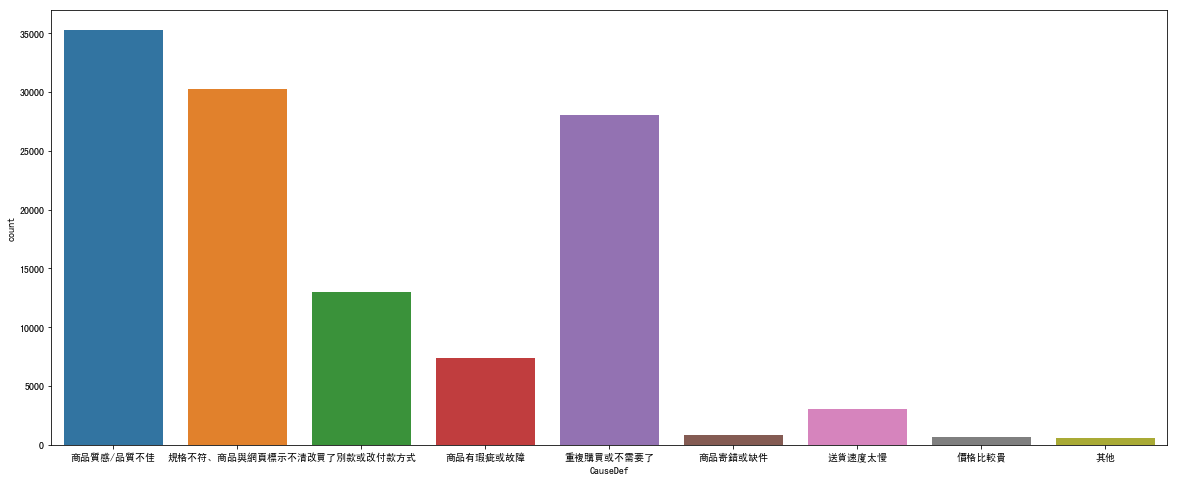

In [7]:
#看退貨狀況
df_period['CauseDef'].value_counts() 
plt.figure(figsize=(20,8))
sns.countplot(data = df_period, x='CauseDef' )

得到一組在2016年有退過貨的會員名單

In [8]:
#期間內有退貨的會員名單
retrun_lst  = df_period[df_period['ReturnGoodsDateId'].notnull()]['MemberId'].unique().tolist()

In [9]:
a = df_period[df_period['ReturnGoodsDateId'].notnull()].groupby(['MemberId', 'OrderGroupCode'])['Quantity'].sum().reset_index()
num_return = a.groupby('MemberId')['OrderGroupCode'].count().reset_index()
num_return.columns = ['MemberId', 'Return']
num_return.head()

,MemberId,Return
0,1912,2
1,2200,1
2,2476,1
3,2943,1
4,3018,1


接下來的會員表現都只看「有交易成功」且「不是贈品」的row

In [11]:
#只取成功交易且是major
df_MajorFinish = df_period[(df_period['IsGift'] == False) & (df_period['IsMajor'] == True) & (df_period['StatusDef'] == 'Finish')]

In [12]:
#檢查有無null
df_MajorFinish.isnull().sum()

DateId                               0
MemberId                             0
OrderGroupCode                       0
TrackSourceTypeDef                   0
TrackDeviceTypeDef                   0
PayProfileTypeDef                    0
SalesOrderSlaveId                    0
SalePageId                           0
IsMajor                              0
IsGift                               0
IsSalePageGift                       0
Quantity                             0
UnitPrice                            0
PromotionDiscount                    0
ECouponId                            0
ECouponDiscount                      0
SalesOrderSlaveTotalPayment          0
SalesOrderSlaveDateTime              0
SalesOrderReceiverId                 0
City                                 0
District                           417
ZipCode                              0
StoreName                       152429
StoreId                         152429
DeliverTypeDef                       0
StatusDef                

考慮會員在一年內的購買頻率。做法是把同一天的發票合併，然後算出每個會員的「平均」購買週期。選擇用mean而不用median的原因，是因為考慮到極端值存在的情況
（例如前半年都固定每兩個月買一次，但後半年變成是半年只買了一次，這可能隱含著重購意願的下降），因此決定用mean來捕捉極端值的情況

In [13]:
#看購買頻率
df_cart = df_MajorFinish.groupby(['DateId','MemberId','OrderGroupCode'])['Quantity', 'SalesOrderSlaveTotalPayment'].sum().reset_index()

In [14]:
df_cart.head()

,DateId,MemberId,OrderGroupCode,Quantity,SalesOrderSlaveTotalPayment
0,2016-01-01,7780,b'\xf6N\xc7U\x92\xa6\r\xa1X\xb3W\xb6`\xd2\xe9\...,2,729.0
1,2016-01-01,25412,b'\xca\x16\x85\x160c-!#\xdf<j\xca\x8e\xd0=T^\x...,1,390.0
2,2016-01-01,32140,"b'\xf1\x97\x96\x82}\x06\xc0c,\x1fo\x94\xf2\xdc...",5,662.0
3,2016-01-01,34279,"b'L\xbb\x02\x8a\xcc\xee\xd3\x8a]\x19\xaa""n\x1d...",5,1484.0
4,2016-01-01,61816,b'\xfd\xac\x02\x1f\x01\x14\xc8\xacYZ\xb4\\\x8a...,8,992.0


In [15]:
#同一天的發票合併
df_daily = df_cart.groupby(['DateId','MemberId'])['Quantity', 'SalesOrderSlaveTotalPayment'].sum().reset_index()
df_daily['DateId'] = df_daily['DateId'].dt.date
df_daily.head()

,DateId,MemberId,Quantity,SalesOrderSlaveTotalPayment
0,2016-01-01,7780,2,729.0
1,2016-01-01,25412,1,390.0
2,2016-01-01,32140,5,662.0
3,2016-01-01,34279,5,1484.0
4,2016-01-01,61816,8,992.0


In [16]:
member_fre = df_daily.groupby('MemberId')['DateId'].apply(list).reset_index()
member_fre.head()

,MemberId,DateId
0,1362,[2016-11-11]
1,1384,"[2016-04-08, 2016-10-20]"
2,1400,[2016-12-28]
3,1448,"[2016-03-24, 2016-06-04, 2016-08-09]"
4,1469,"[2016-06-24, 2016-07-17, 2016-09-23, 2016-12-09]"


In [17]:
def f(row):
    fre_lst = []
    lst = row['DateId'] 
    for i in range(len(lst)):
        if i == 0:
            continue
        else:
            delta = lst[i] - lst[i-1]
        fre_lst.append(delta.days)
    return fre_lst

member_fre['frequency'] = member_fre.apply(f,axis=1)

In [18]:
def mean(row):
    lst = row['frequency'] 
    mean = np.mean(np.array(lst))
    return mean

def std(row):
    lst = row['frequency'] 
    std = np.std(np.array(lst))
    return std

member_fre['frequency_mean'] = member_fre.apply(mean,axis=1) #看平均，因為需要考慮到極端值
#member_fre['median'] = member_fre.apply(b,axis=1)
member_fre['frequency_std'] = member_fre.apply(std,axis=1)

每個會員的平均購買週期整理後，如表，包含平均值跟std

In [19]:
member_fre.head()

,MemberId,DateId,frequency,frequency_mean,frequency_std
0,1362,[2016-11-11],[],NaN,NaN
1,1384,"[2016-04-08, 2016-10-20]",[195],195.0,0.000000
2,1400,[2016-12-28],[],NaN,NaN
3,1448,"[2016-03-24, 2016-06-04, 2016-08-09]","[72, 66]",69.0,3.000000
4,1469,"[2016-06-24, 2016-07-17, 2016-09-23, 2016-12-09]","[23, 68, 77]",56.0,23.622024


In [20]:
member_fre.isnull().sum() #null為只買一次的人

MemberId               0
DateId                 0
frequency              0
frequency_mean    174774
frequency_std     174774
dtype: int64

平均購買週期為NaN的表示只購買一次，因此補值365

In [22]:
#把只買一次的人mean補值365
indices= member_fre['frequency_mean'].isnull()
member_fre.loc[indices,'frequency_mean'] = member_fre.loc[indices,'frequency_mean'].fillna(365)

接下來要排出會員的貢獻度類別。我們是從一年內購買的總數量和總價格，來考慮會員的貢獻。

先看P和Q的分佈狀況

In [ ]:
#groupby會員，看一年內P和Q的總數分佈
df_MajorFinish.groupby('MemberId')['Quantity', 'SalesOrderSlaveTotalPayment'].sum().plot(kind='scatter', x='Quantity', y='SalesOrderSlaveTotalPayment')

In [24]:
#看會員在期間內的貢獻
qp = df_MajorFinish.groupby('MemberId')['Quantity', 'SalesOrderSlaveTotalPayment'].sum()
qp.describe()

,Quantity,SalesOrderSlaveTotalPayment
count,257148.000000,257148.000000
mean,6.763276,1524.872941
std,7.589862,1752.599871
min,1.000000,1.000000
25%,3.000000,613.000000
50%,4.000000,996.000000
75%,8.000000,1781.000000
max,357.000000,79968.000000


In [25]:
#檢查q在90%以上的分佈
np.quantile(qp['Quantity'],0.9), np.quantile(qp['Quantity'],0.95),np.quantile(qp['Quantity'],0.99)

(14.0, 20.0, 37.0)

In [26]:
#檢查p在90%以上的分佈
np.quantile(qp['SalesOrderSlaveTotalPayment'],0.9), np.quantile(qp['SalesOrderSlaveTotalPayment'],0.95),np.quantile(qp['SalesOrderSlaveTotalPayment'],0.99)

(3125.0, 4431.0, 8391.529999999999)

從分佈來各切成四等份(q25,q50,q75)

In [27]:
#先按照分佈來切成四等份 #問題：數字會很醜陋，較不具商業意義
q25 = np.quantile(qp['Quantity'],0.25)
q50= np.quantile(qp['Quantity'],0.5)
q75 = np.quantile(qp['Quantity'],0.75)

p25 = np.quantile(qp['SalesOrderSlaveTotalPayment'],0.25)
p50= np.quantile(qp['SalesOrderSlaveTotalPayment'],0.5)
p75 = np.quantile(qp['SalesOrderSlaveTotalPayment'],0.75)

In [28]:
#同個會員的資料合併，做label 
df_label = df_MajorFinish.groupby('MemberId')['Quantity', 'SalesOrderSlaveTotalPayment'].sum()
df_label.head()

,Quantity,SalesOrderSlaveTotalPayment
MemberId,,
1362,4,591.0
1384,4,1147.0
1400,2,798.0
1448,13,3078.0
1469,9,2768.0


再依貢獻度分成ABCDEF六類，A是購買數量最多且總消費金額最高，F是購買數量最少且總消費金額最低

每個會員各自標上貢獻度類別

In [29]:
def label(row):
    q = row['Quantity']
    p = row['SalesOrderSlaveTotalPayment']
    if (p>p75) & (q>q75):
        label = 'A'
    elif (p>p50) & (q>q50):
        label = 'B'
    elif (p50<p<=75) & (q>q50):
        label = 'B'
    elif (p>p50) & (q<=q50):
        label = 'C'
    elif (p<=p50) & (q>q50):
        label = 'D'
    elif (p<=p25) & (q<=q25):
        label = 'F'
    else:
        label = 'E'
   
    return label

df_label['label'] = df_label.apply(label, axis=1)       

In [30]:
df_label['label'].value_counts() 

B    60233
E    58240
F    56386
A    53003
C    14964
D    14322
Name: label, dtype: int64

In [31]:
df_label.head() #待會要合併至主df

,Quantity,SalesOrderSlaveTotalPayment,label
MemberId,,,
1362,4,591.0,E
1384,4,1147.0,C
1400,2,798.0,E
1448,13,3078.0,A
1469,9,2768.0,A


In [32]:
#看單次購買的sales_p分佈
df_MajorFinish['sales_p'] = (df_MajorFinish['SalesOrderSlaveTotalPayment'] / df_MajorFinish['Quantity'])
#df['sales_p'].describe()

接下來考慮購買的商品類別。因為我們沒有商品詳細的資訊，因此這邊我們假設商品的單價會跟商品品質呈高度正相關，那麼商品的價格本身就會反映所屬的商品類別（這邊我們只能這樣粗略的分類）。這邊我們希望整理出每個會員在單次消費時，各自買了幾個不同的商品類別。


In [33]:
#看單價的分佈（這邊假設價格反映商品品質）
df_MajorFinish['UnitPrice'].describe() 

count    1.704075e+06
mean     2.589213e+02
std      1.095872e+02
min      1.000000e+00
25%      1.990000e+02
50%      2.250000e+02
75%      2.990000e+02
max      2.800000e+03
Name: UnitPrice, dtype: float64

In [34]:
#確認unitprice在90%以上的分佈
np.quantile(df_MajorFinish['UnitPrice'],0.9), np.quantile(df_MajorFinish['UnitPrice'],0.95),np.quantile(df_MajorFinish['UnitPrice'],0.99)

(399.0, 450.0, 590.0)

發現不是一個row只包含一個quantity，因此需要先整理

In [35]:
df_MajorFinish['Quantity'].value_counts() #發現有些欄位的q>=2，需要處理

1     1674294
2       26536
3        2106
4         688
5         250
6          92
10         39
7          35
8          25
9          10
Name: Quantity, dtype: int64

In [36]:
df_MajorFinish.shape

(1704075, 29)

In [37]:
#重複q>=2的row
repeats = df_MajorFinish['Quantity'].values
df_temp = pd.DataFrame(np.repeat(df_MajorFinish.values, repeats, axis=0))
df_temp.columns = df_MajorFinish.columns
df_temp.shape

(1739163, 29)

In [38]:
df_temp.head()

,DateId,MemberId,OrderGroupCode,TrackSourceTypeDef,TrackDeviceTypeDef,PayProfileTypeDef,SalesOrderSlaveId,SalePageId,IsMajor,IsGift,IsSalePageGift,Quantity,UnitPrice,PromotionDiscount,ECouponId,ECouponDiscount,SalesOrderSlaveTotalPayment,SalesOrderSlaveDateTime,SalesOrderReceiverId,City,District,ZipCode,StoreName,StoreId,DeliverTypeDef,StatusDef,ReturnGoodsDateId,CauseDef,sales_p
0,2016-01-03 00:00:00,430291,b'\\\xf4X\xe9i\xf9\x1a{\xabkp5\x08u\xa0s\xb1\x...,iOSApp,Mobile,SevenEleven,9107318,1740458,True,False,False,1,250,-111,9118,-24,115,2016-01-03 14:30:32.467,3029297,基隆市,七堵區,206,篤鑫門市,119216,SevenEleven,Finish,NaN,NaN,115
1,2016-01-03 00:00:00,430291,b'\\\xf4X\xe9i\xf9\x1a{\xabkp5\x08u\xa0s\xb1\x...,iOSApp,Mobile,SevenEleven,9107319,1677964,True,False,False,1,280,-120,9118,-26,134,2016-01-03 14:30:32.500,3029297,基隆市,七堵區,206,篤鑫門市,119216,SevenEleven,Finish,NaN,NaN,134
2,2016-01-03 00:00:00,430291,b'\\\xf4X\xe9i\xf9\x1a{\xabkp5\x08u\xa0s\xb1\x...,iOSApp,Mobile,SevenEleven,9107320,1488466,True,False,False,1,299,0,9118,-50,249,2016-01-03 14:30:32.500,3029297,基隆市,七堵區,206,篤鑫門市,119216,SevenEleven,Finish,NaN,NaN,249
3,2016-01-03 00:00:00,2306666,"b""\xbd\xb1\xc1\xa6\xb0\x11\x02\xd0\xf1\x9a!\xe...",iOSApp,Mobile,SevenEleven,9107453,1699026,True,False,False,1,520,0,9118,-36,484,2016-01-03 14:34:08.547,3029344,高雄市,左營區,813,豐園門市,999511,SevenEleven,Finish,NaN,NaN,484
4,2016-01-03 00:00:00,2306666,"b""\xbd\xb1\xc1\xa6\xb0\x11\x02\xd0\xf1\x9a!\xe...",iOSApp,Mobile,SevenEleven,9107454,1760577,True,False,False,1,790,0,9118,-56,734,2016-01-03 14:34:08.560,3029344,高雄市,左營區,813,豐園門市,999511,SevenEleven,Finish,NaN,NaN,734


整理好之後，再重新去看商品單價的分佈

In [39]:
df_temp['UnitPrice'].astype(int).describe() 

count    1.739163e+06
mean     2.581516e+02
std      1.094069e+02
min      1.000000e+00
25%      1.990000e+02
50%      2.250000e+02
75%      2.990000e+02
max      2.800000e+03
Name: UnitPrice, dtype: float64

In [40]:
np.quantile(df_temp['UnitPrice'],0.90)

399.0

這時一樣按照單價分成五種商品類別(q25,q50,q75,q90,q100)

In [41]:
#商品分類
up25= np.quantile(df_temp['UnitPrice'],0.25)
up50= np.quantile(df_temp['UnitPrice'],0.50)
up75= np.quantile(df_temp['UnitPrice'],0.75)
up90= np.quantile(df_temp['UnitPrice'],0.90)
up100= np.quantile(df_temp['UnitPrice'],1)

bins = [0,up25,up50,up75,up90,up100] #按照分佈來切
df_temp['cut_UnitPrice'] = pd.cut(df_temp['UnitPrice'], bins = bins)

In [42]:
df_temp = pd.get_dummies(df_temp, columns = ['cut_UnitPrice'], prefix = ['cut_UnitPrice'])

In [43]:
df_temp.head()

,DateId,MemberId,OrderGroupCode,TrackSourceTypeDef,TrackDeviceTypeDef,PayProfileTypeDef,SalesOrderSlaveId,SalePageId,IsMajor,IsGift,IsSalePageGift,Quantity,UnitPrice,PromotionDiscount,ECouponId,ECouponDiscount,SalesOrderSlaveTotalPayment,SalesOrderSlaveDateTime,SalesOrderReceiverId,City,District,ZipCode,StoreName,StoreId,DeliverTypeDef,StatusDef,ReturnGoodsDateId,CauseDef,sales_p,"cut_UnitPrice_(0.0, 199.0]","cut_UnitPrice_(199.0, 225.0]","cut_UnitPrice_(225.0, 299.0]","cut_UnitPrice_(299.0, 399.0]","cut_UnitPrice_(399.0, 2800.0]"
0,2016-01-03 00:00:00,430291,b'\\\xf4X\xe9i\xf9\x1a{\xabkp5\x08u\xa0s\xb1\x...,iOSApp,Mobile,SevenEleven,9107318,1740458,True,False,False,1,250,-111,9118,-24,115,2016-01-03 14:30:32.467,3029297,基隆市,七堵區,206,篤鑫門市,119216,SevenEleven,Finish,NaN,NaN,115,0,0,1,0,0
1,2016-01-03 00:00:00,430291,b'\\\xf4X\xe9i\xf9\x1a{\xabkp5\x08u\xa0s\xb1\x...,iOSApp,Mobile,SevenEleven,9107319,1677964,True,False,False,1,280,-120,9118,-26,134,2016-01-03 14:30:32.500,3029297,基隆市,七堵區,206,篤鑫門市,119216,SevenEleven,Finish,NaN,NaN,134,0,0,1,0,0
2,2016-01-03 00:00:00,430291,b'\\\xf4X\xe9i\xf9\x1a{\xabkp5\x08u\xa0s\xb1\x...,iOSApp,Mobile,SevenEleven,9107320,1488466,True,False,False,1,299,0,9118,-50,249,2016-01-03 14:30:32.500,3029297,基隆市,七堵區,206,篤鑫門市,119216,SevenEleven,Finish,NaN,NaN,249,0,0,1,0,0
3,2016-01-03 00:00:00,2306666,"b""\xbd\xb1\xc1\xa6\xb0\x11\x02\xd0\xf1\x9a!\xe...",iOSApp,Mobile,SevenEleven,9107453,1699026,True,False,False,1,520,0,9118,-36,484,2016-01-03 14:34:08.547,3029344,高雄市,左營區,813,豐園門市,999511,SevenEleven,Finish,NaN,NaN,484,0,0,0,0,1
4,2016-01-03 00:00:00,2306666,"b""\xbd\xb1\xc1\xa6\xb0\x11\x02\xd0\xf1\x9a!\xe...",iOSApp,Mobile,SevenEleven,9107454,1760577,True,False,False,1,790,0,9118,-56,734,2016-01-03 14:34:08.560,3029344,高雄市,左營區,813,豐園門市,999511,SevenEleven,Finish,NaN,NaN,734,0,0,0,0,1


In [44]:
df_temp.columns.tolist()[:-6:-1]

['cut_UnitPrice_(399.0, 2800.0]',
 'cut_UnitPrice_(299.0, 399.0]',
 'cut_UnitPrice_(225.0, 299.0]',
 'cut_UnitPrice_(199.0, 225.0]',
 'cut_UnitPrice_(0.0, 199.0]']

如表，可以看到每個會員，在不同次消費時，所購買的商品類型的數量

In [45]:
#同個會員的資料合併 #購物車編號是unique的
cut_names = df_temp.columns.tolist()[:-6:-1]
groupby_item = df_temp.groupby(['MemberId','OrderGroupCode'])[cut_names].sum()
groupby_item   

cut_UnitPrice_(399.0, 2800.0]  \
MemberId OrderGroupCode                                                                      
1362     b'\xffNo\xc3\xdb\x84\r-g\xe6\x15eL\x85\xd6\x94m...                              0   
1384     b'\x11v\xabF\xee\xf7\x1foK\xae\xf8\xf6C\xb5\xf9...                              1   
         b'\x83\xc9\xb0\r\xdd\xa0\x1d\x19\xad\x88\x00\x1...                              0   
1400     b'%/\x1f\xa9f\x99\x8fa&\xb6\x9d\x86l\xf8[\xd5\x...                              0   
1448     b'>n\x81\x12\x01\xe7\xd3\xcfO\x1b\x91\xf3!\x13\...                              0   
         b'\x99n&27\xb6\x82&\xec\xe0\xfc\xc3b)\x7f; \xfb...                              0   
         b'\xd7\r.\x97\x9a\xd9~\xc1\x07\xb1\xcep\x10\xcf...                              0   
1469     b"\xc8P#3'\xc1\xc4\xb4T?\x9agq\xd1%\x13D\xff\xc...                              0   
         b'C(Q\xf0n\x0c\xfc\xedR\x11\xaej\x11\xdf\xb1\x8...                              0   
         b'\x01Bz\x01x\xa0\xda\rb\x87u\xa5\xecB\x0b\x9cQ...                              0   
         b't\xa2\xd0oyh\xb5\xcc|\x1b\xb1\xee\xab\xc2\x0e...                              2   
1490     b"\xaf\r\xeb;\xcf'rL\x0b73O''\x97\x07\xcc\x15/\...                              0   
         b'\xc9\xbc\xcd\x85\xf9\x95\xf4\x1d\xef\xca\xaf:...                              0   
1514     b'\xaf\xbd\xea+Y\xaa\xd7\x9b\x87\\~\xc7oU\xa9\x...                              1   
1622     b"\xfe\x96\xb7\xd6\x9b\xd0\x0c\x13\xda'\xbcv\xb...                              1   
1663     b'\x008\x1e\xa9Z\x94})#\xf6zE&\x9fC\xc9q\xe1]\xb4'                              1   
1683     b'\xbd\x9f0My\x95\xd9G\xd4\xef\xf2\xdfR!e\xe6\x...                              0   
1710     b'T\x13`\x86\xa2d"\x93\xa9\x9e\xdf~\n\xaa\x03\x...                              0   
1729     b"\x8a\xec\x13\xc7&A\x15\xadd2'\xd1\x8a\n\x0c\x...                              0   
1734     b'1\x0b\xfep\x85\x00a\x89\x98\xfb|nto\xad\x81C\...                              0   
1743     b'\xcb\xfc\r&\x0e7d\xea\xd1\x94\xfd\xcbG\x9dP\x...                              0   
         b'\xfe\xeb\xeb\xad\xaa\xa8\x97\xfa\x17>F\xa5~m\...                              0   
1746     b'D\xe7\xb2Am\x91\xe5\x9e\x19{\xed<\x9c\xfd\xfb...                              0   
1787     b'5f\t\x97\x15\tmW\xe9l\x88l\x93\x0eo\xc4\x06)72'                               0   
1800     b'\x9aI\xcb\xfcA\x1e4\x8e\xb1P\xda\xa6w30\xe9\x...                              0   
         b'\xe7\xac\xa0\xe9\x1a\xde\xc3\xa2|\xcf\xfb\xdb...                              0   
1870     b'<N\x9c/\x90^\x80c\xa8v\x1c\x1d4\x7fD\xad\xd2N...                              0   
         b'R\xd2&X\n\x1b\xc7S\x86\xc2\xc9\xd1<\x80\x16\x...                              0   
         b'\x19\xaa9\xb1\x98m\xb3p\xf8~\xc5du\xe0\x1eb\x...                              0   
         b'\xafZb)A\xc2\xf8\xf3s\x95\x917\x89`\xb2i\xea\...                              0   
...                                                                                    ...   
4596084  b'S\xee\xb3\xf4\x7f\x03\xbe\xa5PZ\x9cz\xd16\xd9...                              0   
4596137  b'$Z\x97\xb7\xb1\xbcZ2T\xb8)\x88\x7f\xa5\x0e\x1...                              1   
4596648  b'\x82\x14\x87\xc1\xf2a\xdcA\x01Zz\x9a\x15p\xf6...                              1   
4596671  b'\x81\xe1,\xf0s\xcd\x84*\x8bW#\x8f\xe8\x81\xbc...                              0   
4596830  b'$\xcf+G\xe3tk\xdd\xc2\xa2\x14\xdb\xfc\xbd\xaa...                              1   
4596851  b'*\x93@\xa1\x02\x93\xa0\x93\xd9\xc3\x1e\xed%T\...                              0   
4597149  b"\x92g\xfbzS\xab\xf6Z\xcd\\\x88@\xfe\xb6\x967\...                              0   
4597203  b'\x15A^-\x82s\xf9\xfc\x0f\x10$!\xfdi\\A\x16|\x...                              0   
4597346  b'z\x03\xf9r\xd2~l3\x1b\xc6j\xb3\xeev\xfe\x18\x...                              0   
4597529  b'B3\xb5C\xc48\xb3\x1d\x8e\xca\xe9\xdb\x9f\xc7\...                              1   
4597822  b'\xa4\xd2

考慮購物的時間（時間、星期幾、季節）

In [46]:
#購買時間拆成day of week和hour of day
df_MajorFinish['SalesOrderSlaveDateTime'] = pd.to_datetime(df_MajorFinish['SalesOrderSlaveDateTime'])
df_MajorFinish['hour'] = df_MajorFinish['SalesOrderSlaveDateTime'].dt.hour
df_MajorFinish['hour'] = df_MajorFinish['hour'] + 1
df_MajorFinish['dayow'] = df_MajorFinish['SalesOrderSlaveDateTime'].dt.weekday
df_MajorFinish['dayow'] = df_MajorFinish['dayow']+ 1

In [47]:
#同個會員、同張發票合併
pq = ['Quantity','SalesOrderSlaveTotalPayment', 'ECouponDiscount', 'PromotionDiscount']
want = ['DateId','MemberId','OrderGroupCode','TrackSourceTypeDef','TrackDeviceTypeDef','PayProfileTypeDef','City','DeliverTypeDef','hour','dayow']
df_tidy = df_MajorFinish.groupby(want, as_index=False)[pq].sum()

In [48]:
#把購物季節也納入考慮
df_tidy['month'] = df_tidy['DateId'].dt.month

In [49]:
#把商品和貢獻度label加上去
df_tidy = pd.merge(df_tidy,groupby_item, on = 'OrderGroupCode', how='outer') #加上商品分類
#df_tidy = pd.merge(df_tidy,df_label['label'], on = 'MemberId', how='outer') #加上label
df_tidy.head()

,DateId,MemberId,OrderGroupCode,TrackSourceTypeDef,TrackDeviceTypeDef,PayProfileTypeDef,City,DeliverTypeDef,hour,dayow,Quantity,SalesOrderSlaveTotalPayment,ECouponDiscount,PromotionDiscount,month,"cut_UnitPrice_(399.0, 2800.0]","cut_UnitPrice_(299.0, 399.0]","cut_UnitPrice_(225.0, 299.0]","cut_UnitPrice_(199.0, 225.0]","cut_UnitPrice_(0.0, 199.0]"
0,2016-01-01,7780,b'\xf6N\xc7U\x92\xa6\r\xa1X\xb3W\xb6`\xd2\xe9\...,Web,Mobile,Family,新北市,Family,2,5,2,729.0,0.0,0.0,1,0,2,0,0,0
1,2016-01-01,25412,b'\xca\x16\x85\x160c-!#\xdf<j\xca\x8e\xd0=T^\x...,Web,PC,Family,台中市,Family,24,5,1,390.0,0.0,0.0,1,0,1,0,0,0
2,2016-01-01,32140,"b'\xf1\x97\x96\x82}\x06\xc0c,\x1fo\x94\xf2\xdc...",AndroidApp,Mobile,SevenEleven,新北市,SevenEleven,18,5,5,662.0,0.0,0.0,1,0,0,1,0,4
3,2016-01-01,34279,"b'L\xbb\x02\x8a\xcc\xee\xd3\x8a]\x19\xaa""n\x1d...",AndroidApp,Mobile,CreditCardOnce,高雄市,Home,10,5,5,1484.0,0.0,-231.0,1,0,3,2,0,0
4,2016-01-01,61816,b'\xfd\xac\x02\x1f\x01\x14\xc8\xacYZ\xb4\\\x8a...,AndroidApp,Mobile,SevenEleven,桃園市,SevenEleven,3,5,8,992.0,0.0,-48.0,1,0,0,0,0,8


把會員資料集中，「有沒有領開卡禮和生日禮」一併納入作為特徵值（因為之前做EDA發現有沒有領開卡禮對消費行為有重大影響）

In [50]:
#根據有沒有領開卡禮設boolean
df_members.loc[df_members.OpenCardPresent == 0, 'get_OpenCardPresent'] = False
df_members.loc[df_members.OpenCardPresent != 0, 'get_OpenCardPresent'] = True
#根據有沒有領生日禮設boolean
df_members.loc[df_members.LastBirthdayPresentYear == 0, 'get_LastBirthdayPresentYear'] = False
df_members.loc[df_members.LastBirthdayPresentYear != 0, 'get_LastBirthdayPresentYear'] = True

In [51]:
#把有沒有生日禮和開卡禮的狀態，merge到df_tidy
df_tidy = pd.merge(df_tidy, df_members[['MemberId', 'get_OpenCardPresent','get_LastBirthdayPresentYear']], on = 'MemberId', how='left')


會員資料集中的性別欄位也納入

In [52]:
#合併性別欄位
df_tidy = pd.merge(df_tidy, df_members[['MemberId', 'GenderTypeDef', 'RegisterSourceTypeDef']], on = 'MemberId', how = 'left')


檢查有無null

In [53]:
df_tidy.isnull().sum()

DateId                                0
MemberId                              0
OrderGroupCode                        0
TrackSourceTypeDef                    0
TrackDeviceTypeDef                    0
PayProfileTypeDef                     0
City                                  0
DeliverTypeDef                        0
hour                                  0
dayow                                 0
Quantity                              0
SalesOrderSlaveTotalPayment           0
ECouponDiscount                       0
PromotionDiscount                     0
month                                 0
cut_UnitPrice_(399.0, 2800.0]         0
cut_UnitPrice_(299.0, 399.0]          0
cut_UnitPrice_(225.0, 299.0]          0
cut_UnitPrice_(199.0, 225.0]          0
cut_UnitPrice_(0.0, 199.0]            0
get_OpenCardPresent                 445
get_LastBirthdayPresentYear         445
GenderTypeDef                    219940
RegisterSourceTypeDef             19875
dtype: int64

有null的補值：
開卡禮跟生日禮是null的改成false （推測應該就沒有領了），性別欄位缺值的直接當成一種資料，註冊管道缺值的也直接當成一種資料

In [54]:
#開卡里跟生日禮是null的改成false
indices= df_tidy['get_OpenCardPresent'].isnull()
df_tidy.loc[indices,'get_OpenCardPresent'] = df_tidy.loc[indices,'get_OpenCardPresent'].fillna(False)
indices= df_tidy['get_LastBirthdayPresentYear'].isnull()
df_tidy.loc[indices,'get_LastBirthdayPresentYear'] = df_tidy.loc[indices,'get_LastBirthdayPresentYear'].fillna(False)

In [55]:
df_tidy.isnull().sum()

DateId                                0
MemberId                              0
OrderGroupCode                        0
TrackSourceTypeDef                    0
TrackDeviceTypeDef                    0
PayProfileTypeDef                     0
City                                  0
DeliverTypeDef                        0
hour                                  0
dayow                                 0
Quantity                              0
SalesOrderSlaveTotalPayment           0
ECouponDiscount                       0
PromotionDiscount                     0
month                                 0
cut_UnitPrice_(399.0, 2800.0]         0
cut_UnitPrice_(299.0, 399.0]          0
cut_UnitPrice_(225.0, 299.0]          0
cut_UnitPrice_(199.0, 225.0]          0
cut_UnitPrice_(0.0, 199.0]            0
get_OpenCardPresent                   0
get_LastBirthdayPresentYear           0
GenderTypeDef                    219940
RegisterSourceTypeDef             19875
dtype: int64

In [56]:
#補缺漏值--> 注意：缺漏都是來自 1)member dataset本身資料就有缺漏(ex.gender) 2)order dataset裡少數人沒在member dataset裡
df_tidy.fillna('N', inplace = True)

把縣市依北中南東分成四大地區

In [57]:
#修改縣市:以地區來分
north = ['台北市','新北市', '桃園市', '新竹市','苗栗縣','新竹縣', '基隆市']
south = ['高雄市','台南市','屏東縣','雲林縣','嘉義縣','嘉義市','屏東市']
mid = ['台中市','彰化縣','南投縣' ]
east = ['宜蘭縣','花蓮縣','台東縣','澎湖縣','台東市']

df_tidy = df_tidy.assign(location_North = np.where(df_tidy['City'].isin(north), 1, 0))
df_tidy = df_tidy.assign(location_South = np.where(df_tidy['City'].isin(south), 1, 0))
df_tidy = df_tidy.assign(location_Mid = np.where(df_tidy['City'].isin(mid), 1, 0))
df_tidy = df_tidy.assign(location_East = np.where(df_tidy['City'].isin(east), 1, 0))

購物時間也改成用分成大類來做標記（避免類別太多）

In [58]:
#修改購物時間
weekday = [1,2,3,4,5]
weekend = [6,7]

df_tidy = df_tidy.assign(Weekend = np.where(df_tidy['dayow'].isin(weekend), 1, 0)) #weekend=1, weekday=0
#df_tidy = df_tidy.assign(South = np.where(df_tidy['City'].isin(south), 1, 0))

In [59]:
midnight = [2,3,4,5,6,7]
morning = [8,9,10,11,12]
afternoon = [13,14,15,16,17]
night = [18,19,20,21,22,23,24,1]

df_tidy = df_tidy.assign(time_Midnight = np.where(df_tidy['hour'].isin(midnight), 1, 0))
df_tidy = df_tidy.assign(time_Morning = np.where(df_tidy['hour'].isin(morning), 1, 0))
df_tidy = df_tidy.assign(time_Afternoon = np.where(df_tidy['hour'].isin(afternoon), 1, 0))
df_tidy = df_tidy.assign(time_Night = np.where(df_tidy['hour'].isin(night), 1, 0))

In [60]:
spring = [3,4,5]
summer = [6,7,8]
fall = [9,10,11]
winter = [12,1,2]

df_tidy = df_tidy.assign(season_spring = np.where(df_tidy['month'].isin(spring), 1, 0))
df_tidy = df_tidy.assign(season_summer = np.where(df_tidy['month'].isin(summer), 1, 0))
df_tidy = df_tidy.assign(season_fall = np.where(df_tidy['month'].isin(fall), 1, 0))
df_tidy = df_tidy.assign(season_winter = np.where(df_tidy['month'].isin(winter), 1, 0))

有沒有使用過ecoupon或promotion

In [61]:
#有沒有使用ecoupon或促銷
df_tidy['ECouponDiscount'] = (df_tidy['ECouponDiscount'] != 0)
df_tidy['PromotionDiscount'] = (df_tidy['PromotionDiscount'] != 0)

其他的類別型資料做one hot encoding

In [62]:
get_dummy = ['TrackSourceTypeDef','TrackDeviceTypeDef','PayProfileTypeDef','DeliverTypeDef','GenderTypeDef', 'RegisterSourceTypeDef']
df_tidy = pd.get_dummies(df_tidy, columns = get_dummy , prefix = get_dummy)


In [63]:
df_tidy.drop(['City','hour','dayow','month'],axis=1, inplace=True)

In [114]:
#把同個會員的資料合併
agg_behavior = df_tidy.groupby('MemberId').sum().reset_index()
agg_behavior.head()

,MemberId,Quantity,SalesOrderSlaveTotalPayment,ECouponDiscount,PromotionDiscount,"cut_UnitPrice_(399.0, 2800.0]","cut_UnitPrice_(299.0, 399.0]","cut_UnitPrice_(225.0, 299.0]","cut_UnitPrice_(199.0, 225.0]","cut_UnitPrice_(0.0, 199.0]",get_OpenCardPresent,get_LastBirthdayPresentYear,location_North,location_South,location_Mid,location_East,Weekend,time_Midnight,time_Morning,time_Afternoon,time_Night,season_spring,season_summer,season_fall,season_winter,TrackSourceTypeDef_AndroidApp,TrackSourceTypeDef_Web,TrackSourceTypeDef_iOSApp,TrackDeviceTypeDef_Mobile,TrackDeviceTypeDef_PC,TrackDeviceTypeDef_Pad,PayProfileTypeDef_CreditCardOnce,PayProfileTypeDef_Family,PayProfileTypeDef_SevenEleven,DeliverTypeDef_Family,DeliverTypeDef_Home,DeliverTypeDef_SevenEleven,GenderTypeDef_Female,GenderTypeDef_Male,GenderTypeDef_N,RegisterSourceTypeDef_AndroidApp,RegisterSourceTypeDef_N,RegisterSourceTypeDef_Web,RegisterSourceTypeDef_iOSApp
0,1362,4,591.0,0.0,0.0,0,0,1,0,3,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0
1,1384,4,1147.0,0.0,0.0,1,0,1,0,2,0.0,0.0,0,2,0,0,0,0,1,0,1,1,0,1,0,0,2,0,2,0,0,2,0,0,0,2,0,0,0,2,0,0,2,0
2,1400,2,798.0,0.0,0.0,0,2,0,0,0,0.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0
3,1448,13,3078.0,0.0,0.0,0,2,4,2,5,0.0,0.0,0,0,3,0,1,0,1,1,1,1,2,0,0,0,3,0,2,1,0,0,0,3,0,0,3,0,0,3,0,0,3,0
4,1469,9,2768.0,0.0,2.0,2,3,2,0,2,4.0,4.0,2,2,0,0,1,3,1,0,0,0,2,1,1,4,0,0,4,0,0,0,2,2,2,0,2,4,0,0,0,4,0,0


In [115]:
agg_behavior.shape

(257148, 44)

加上一年內的購買頻率、購買次數、是否退貨過，以及在2016年的貢獻度label

In [116]:
#加上購買頻率
agg_behavior = pd.merge(agg_behavior, member_fre[['MemberId','frequency_mean']], on = 'MemberId', how='left')

In [117]:
#加上購物次數
Npurchase = df_tidy.groupby('MemberId')['OrderGroupCode'].count().reset_index()
Npurchase.columns = ['MemberId', 'Npurchase']
agg_behavior = pd.merge(agg_behavior, Npurchase, on = 'MemberId', how='left')

In [118]:
#加上是否換貨
agg_behavior = pd.merge(agg_behavior, num_return, on = 'MemberId', how='left')
agg_behavior.fillna(0, inplace = True) #沒退過貨的補上0

In [119]:
#加上label
agg_behavior = pd.merge(agg_behavior,df_label['label'], on = 'MemberId', how='left') 

終於，我們得到了一個乾淨的資料表，可以看見每個會員在2016年的一年內消費的表現（包含金額、次數、管道、商品類別等等）

In [120]:
agg_behavior.head()

,MemberId,Quantity,SalesOrderSlaveTotalPayment,ECouponDiscount,PromotionDiscount,"cut_UnitPrice_(399.0, 2800.0]","cut_UnitPrice_(299.0, 399.0]","cut_UnitPrice_(225.0, 299.0]","cut_UnitPrice_(199.0, 225.0]","cut_UnitPrice_(0.0, 199.0]",get_OpenCardPresent,get_LastBirthdayPresentYear,location_North,location_South,location_Mid,location_East,Weekend,time_Midnight,time_Morning,time_Afternoon,time_Night,season_spring,season_summer,season_fall,season_winter,TrackSourceTypeDef_AndroidApp,TrackSourceTypeDef_Web,TrackSourceTypeDef_iOSApp,TrackDeviceTypeDef_Mobile,TrackDeviceTypeDef_PC,TrackDeviceTypeDef_Pad,PayProfileTypeDef_CreditCardOnce,PayProfileTypeDef_Family,PayProfileTypeDef_SevenEleven,DeliverTypeDef_Family,DeliverTypeDef_Home,DeliverTypeDef_SevenEleven,GenderTypeDef_Female,GenderTypeDef_Male,GenderTypeDef_N,RegisterSourceTypeDef_AndroidApp,RegisterSourceTypeDef_N,RegisterSourceTypeDef_Web,RegisterSourceTypeDef_iOSApp,frequency_mean,Npurchase,Return,label
0,1362,4,591.0,0.0,0.0,0,0,1,0,3,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,365.0,1,0.0,E
1,1384,4,1147.0,0.0,0.0,1,0,1,0,2,0.0,0.0,0,2,0,0,0,0,1,0,1,1,0,1,0,0,2,0,2,0,0,2,0,0,0,2,0,0,0,2,0,0,2,0,195.0,2,0.0,C
2,1400,2,798.0,0.0,0.0,0,2,0,0,0,0.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,365.0,1,0.0,E
3,1448,13,3078.0,0.0,0.0,0,2,4,2,5,0.0,0.0,0,0,3,0,1,0,1,1,1,1,2,0,0,0,3,0,2,1,0,0,0,3,0,0,3,0,0,3,0,0,3,0,69.0,3,0.0,A
4,1469,9,2768.0,0.0,2.0,2,3,2,0,2,4.0,4.0,2,2,0,0,1,3,1,0,0,0,2,1,1,4,0,0,4,0,0,0,2,2,2,0,2,4,0,0,0,4,0,0,56.0,4,0.0,A


### 數值型欄位處理偏態問題

剛剛我們已經把類別型欄位都做改成是用dummy來表示，現在處理數值型欄位（購物總金額、購物總數、購物週期）。

因為都skewness都很大，因此我統一取ln(1+x)，除了可以讓分佈接近常態之外，也可以確保標準化。

Quantity skewness : 6.10


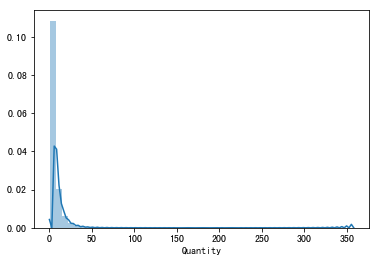

SalesOrderSlaveTotalPayment skewness : 6.53


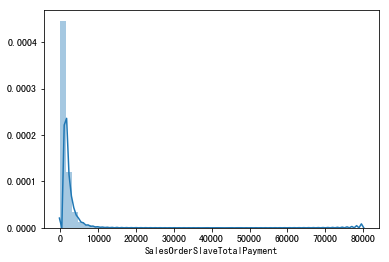

frequency_mean skewness : -0.91


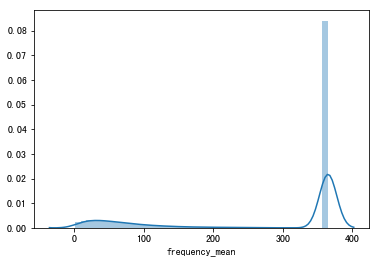

In [121]:
#數值型欄位調整 --> 非常偏
numeric_col = ['Quantity', 'SalesOrderSlaveTotalPayment','frequency_mean' ]
for col in numeric_col:
    print('%s skewness : %0.2f'% (col, agg_behavior[col].skew(axis = 0, skipna = True)))
    sns.distplot(agg_behavior[col])
    plt.show()    

Quantity skewness : 0.63


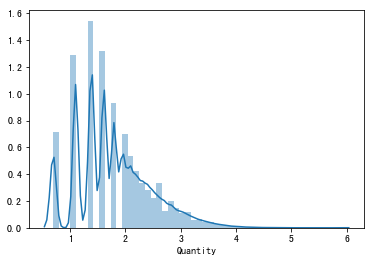

SalesOrderSlaveTotalPayment skewness : 0.19


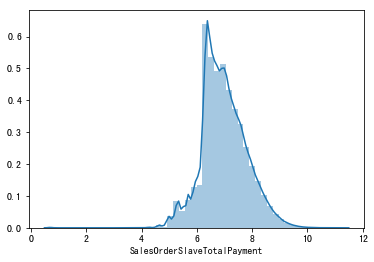

frequency_mean skewness : -1.63


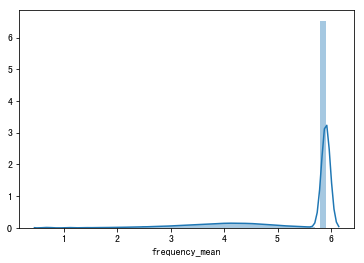

In [122]:
#取log
for col in numeric_col:
    agg_behavior['log_'+ col] = np.log1p(agg_behavior[col])
    print('%s skewness : %0.2f'% (col, np.log1p(agg_behavior[col]).skew(axis = 0, skipna = True)))
    sns.distplot(np.log1p(agg_behavior[col]))
    plt.show()

In [123]:
agg_behavior.drop(numeric_col ,axis=1, inplace=True)
agg_behavior.head()

,MemberId,ECouponDiscount,PromotionDiscount,"cut_UnitPrice_(399.0, 2800.0]","cut_UnitPrice_(299.0, 399.0]","cut_UnitPrice_(225.0, 299.0]","cut_UnitPrice_(199.0, 225.0]","cut_UnitPrice_(0.0, 199.0]",get_OpenCardPresent,get_LastBirthdayPresentYear,location_North,location_South,location_Mid,location_East,Weekend,time_Midnight,time_Morning,time_Afternoon,time_Night,season_spring,season_summer,season_fall,season_winter,TrackSourceTypeDef_AndroidApp,TrackSourceTypeDef_Web,TrackSourceTypeDef_iOSApp,TrackDeviceTypeDef_Mobile,TrackDeviceTypeDef_PC,TrackDeviceTypeDef_Pad,PayProfileTypeDef_CreditCardOnce,PayProfileTypeDef_Family,PayProfileTypeDef_SevenEleven,DeliverTypeDef_Family,DeliverTypeDef_Home,DeliverTypeDef_SevenEleven,GenderTypeDef_Female,GenderTypeDef_Male,GenderTypeDef_N,RegisterSourceTypeDef_AndroidApp,RegisterSourceTypeDef_N,RegisterSourceTypeDef_Web,RegisterSourceTypeDef_iOSApp,Npurchase,Return,label,log_Quantity,log_SalesOrderSlaveTotalPayment,log_frequency_mean
0,1362,0.0,0.0,0,0,1,0,3,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0.0,E,1.609438,6.383507,5.902633
1,1384,0.0,0.0,1,0,1,0,2,0.0,0.0,0,2,0,0,0,0,1,0,1,1,0,1,0,0,2,0,2,0,0,2,0,0,0,2,0,0,0,2,0,0,2,0,2,0.0,C,1.609438,7.045777,5.278115
2,1400,0.0,0.0,0,2,0,0,0,0.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0.0,E,1.098612,6.683361,5.902633
3,1448,0.0,0.0,0,2,4,2,5,0.0,0.0,0,0,3,0,1,0,1,1,1,1,2,0,0,0,3,0,2,1,0,0,0,3,0,0,3,0,0,3,0,0,3,0,3,0.0,A,2.639057,8.032360,4.248495
4,1469,0.0,2.0,2,3,2,0,2,4.0,4.0,2,2,0,0,1,3,1,0,0,0,2,1,1,4,0,0,4,0,0,0,2,2,2,0,2,4,0,0,0,4,0,0,4,0.0,A,2.302585,7.926242,4.043051


### 預測目標：第二年度的排名

接下來整理2017年度的資料，目的是得到會員在該年度的貢獻度類別，作為預測的目標。

過程跟前面都一樣

In [124]:
#先選時間
next_period = df_orders[(df_orders['DateId'] >= '2017-01-01') & (df_orders['DateId'] <= '2017-12-31')]

#只取成功交易且是major
next_MajorFinish = next_period[(next_period['IsGift'] == False) & (next_period['IsMajor'] == True) & (next_period['StatusDef'] == 'Finish')]

In [125]:
next_qp = next_MajorFinish.groupby('MemberId')['Quantity', 'SalesOrderSlaveTotalPayment'].sum()
next_qp.describe()

,Quantity,SalesOrderSlaveTotalPayment
count,232270.000000,232270.000000
mean,7.074543,1696.067977
std,8.128022,2019.591833
min,1.000000,1.000000
25%,3.000000,697.000000
50%,5.000000,1093.000000
75%,8.000000,1956.000000
max,450.000000,98294.000000


In [126]:
#確認q在90%以上的分佈
np.quantile(next_qp['Quantity'],0.9), np.quantile(next_qp['Quantity'],0.95),np.quantile(next_qp['Quantity'],0.99)

(14.0, 20.0, 39.0)

In [127]:
#確認p在90%以上的分佈
np.quantile(next_qp['SalesOrderSlaveTotalPayment'],0.9), np.quantile(next_qp['SalesOrderSlaveTotalPayment'],0.95),np.quantile(next_qp['SalesOrderSlaveTotalPayment'],0.99)

(3450.0, 4893.0, 9549.309999999998)

In [128]:
#先按照分佈來切成四等份 #問題：數字會很醜陋，較不具商業意義
q25 = np.quantile(next_qp['Quantity'],0.25)
q50= np.quantile(next_qp['Quantity'],0.5)
q75 = np.quantile(next_qp['Quantity'],0.75)

p25 = np.quantile(next_qp['SalesOrderSlaveTotalPayment'],0.25)
p50= np.quantile(next_qp['SalesOrderSlaveTotalPayment'],0.5)
p75 = np.quantile(next_qp['SalesOrderSlaveTotalPayment'],0.75)


In [129]:
def next_label(row):
    q = row['Quantity']
    p = row['SalesOrderSlaveTotalPayment']
    if (p>p75) & (q>q75):
        label = 'A'
    elif (p>p50) & (q>q50):
        label = 'B'
    elif (p50<p<=75) & (q>q50):
        label = 'B'
    elif (p>p50) & (q<=q50):
        label = 'C'
    elif (p<=p50) & (q>q50):
        label = 'D'
    elif (p<=p25) & (q<=q25):
        label = 'F'
    else:
        label = 'E'
   
    return label

next_qp['label'] = next_qp.apply(next_label, axis=1) 
next_qp['label'].value_counts() 

E    58356
F    52595
A    49757
B    42878
C    23477
D     5207
Name: label, dtype: int64

如表，得到2017年會員的貢獻度類別

In [130]:
next_qp.head()

,Quantity,SalesOrderSlaveTotalPayment,label
MemberId,,,
1384,2,721.0,E
1391,8,1747.0,B
1448,6,1444.0,B
1474,3,535.0,F
1783,32,5029.0,A


### 對照兩年度的會員表現

我們把第二年度的會員貢獻度類別merge到第一年的資料集

這邊要注意的是，2016年有消費的會員有很高比例並沒有在2017年消費，因此在2017年會被標記為"Loss"，表示為流失客戶

In [131]:
#把第二年的結果合併到第一年
agg_behavior = pd.merge(agg_behavior, next_qp['label'], on = 'MemberId', how='left')
agg_behavior.fillna('Loss', inplace=True) #第二年沒有再購物的人

In [132]:
#對照表
compare = agg_behavior[['MemberId', 'label_x', 'label_y']].set_index('MemberId')
compare.head()

,label_x,label_y
MemberId,,
1362,E,Loss
1384,C,E
1400,E,Loss
1448,A,B
1469,A,Loss


In [156]:
compare[compare['label_y'] != 'Loss']

,label_x,label_y
MemberId,,
1384,C,E
1448,A,B
1912,A,A
2366,F,E
2646,F,E
2709,E,E
2721,E,B
2738,B,E
3036,B,A


In [133]:
#把第一年的rank數值化
def encode(row):
    dict = {'A':6, 'B':5, 'C':4, 'D':3, 'E':2, 'F':1}
    label = row['label_x']
    rank = dict[label]
    return rank

agg_behavior['rank_x'] = agg_behavior.apply(encode, axis=1)    

In [136]:
agg_behavior.shape

(257148, 50)

In [134]:
agg_behavior.head()

,MemberId,ECouponDiscount,PromotionDiscount,"cut_UnitPrice_(399.0, 2800.0]","cut_UnitPrice_(299.0, 399.0]","cut_UnitPrice_(225.0, 299.0]","cut_UnitPrice_(199.0, 225.0]","cut_UnitPrice_(0.0, 199.0]",get_OpenCardPresent,get_LastBirthdayPresentYear,location_North,location_South,location_Mid,location_East,Weekend,time_Midnight,time_Morning,time_Afternoon,time_Night,season_spring,season_summer,season_fall,season_winter,TrackSourceTypeDef_AndroidApp,TrackSourceTypeDef_Web,TrackSourceTypeDef_iOSApp,TrackDeviceTypeDef_Mobile,TrackDeviceTypeDef_PC,TrackDeviceTypeDef_Pad,PayProfileTypeDef_CreditCardOnce,PayProfileTypeDef_Family,PayProfileTypeDef_SevenEleven,DeliverTypeDef_Family,DeliverTypeDef_Home,DeliverTypeDef_SevenEleven,GenderTypeDef_Female,GenderTypeDef_Male,GenderTypeDef_N,RegisterSourceTypeDef_AndroidApp,RegisterSourceTypeDef_N,RegisterSourceTypeDef_Web,RegisterSourceTypeDef_iOSApp,Npurchase,Return,label_x,log_Quantity,log_SalesOrderSlaveTotalPayment,log_frequency_mean,label_y,rank_x
0,1362,0.0,0.0,0,0,1,0,3,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0.0,E,1.609438,6.383507,5.902633,Loss,2
1,1384,0.0,0.0,1,0,1,0,2,0.0,0.0,0,2,0,0,0,0,1,0,1,1,0,1,0,0,2,0,2,0,0,2,0,0,0,2,0,0,0,2,0,0,2,0,2,0.0,C,1.609438,7.045777,5.278115,E,4
2,1400,0.0,0.0,0,2,0,0,0,0.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0.0,E,1.098612,6.683361,5.902633,Loss,2
3,1448,0.0,0.0,0,2,4,2,5,0.0,0.0,0,0,3,0,1,0,1,1,1,1,2,0,0,0,3,0,2,1,0,0,0,3,0,0,3,0,0,3,0,0,3,0,3,0.0,A,2.639057,8.032360,4.248495,B,6
4,1469,0.0,2.0,2,3,2,0,2,4.0,4.0,2,2,0,0,1,3,1,0,0,0,2,1,1,4,0,0,4,0,0,0,2,2,2,0,2,4,0,0,0,4,0,0,4,0.0,A,2.302585,7.926242,4.043051,Loss,6


最終我們會有一個完整的資料集，每個row是特定會員在2016整年度的消費行為，並且也知道他分別在2016年和2017年的貢獻度類別（包含是否流失）

接下來就可以丟到機器學習模型裡面去做訓練了

### ML：從第一年的顧客行為，預測第二年的所屬客群

In [137]:
from sklearn.model_selection import train_test_split
train_Y = agg_behavior['label_y']

drop_list = ['label_x', 'MemberId', 'label_y']
train_X = agg_behavior.drop(drop_list ,axis=1)

train_X = train_X.values
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.2)

In [189]:
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_curve, auc, recall_score, f1_score, precision_score

### Random Forest

我先選用RF，因為出來的結果較具解釋性，bagging也能讓預測出來的結果較準。

下面我先畫了幾張重要參數值對應的accuracy rate的圖，選擇能讓表現最好的參數值。

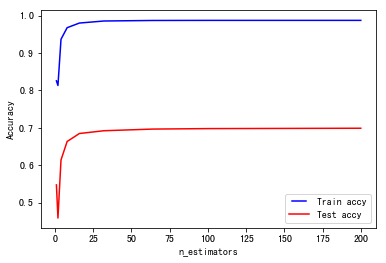

In [142]:
from sklearn.ensemble import RandomForestClassifier
#find the sweet spot --> choose n=32
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(train_X, train_Y)
    train_pred = rf.predict(train_X)
    
    accy_train = accuracy_score(train_Y, train_pred)
    train_results.append(accy_train)
    pred_Y = rf.predict(test_X)
    accy_test = accuracy_score(test_Y, pred_Y)
    test_results.append(accy_test)
    

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train accy')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test accy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.show()

In [143]:
test_results, train_results

([0.5475209021971612,
  0.4589733618510597,
  0.6141746062609372,
  0.6634843476570095,
  0.6848337546179273,
  0.6922613260742757,
  0.6966945362628816,
  0.697977833949057,
  0.6989694730701925],
 [0.8255670383729182,
  0.8132394831759983,
  0.936777530405701,
  0.9676061404446864,
  0.9800260550851165,
  0.9855141504389504,
  0.9869432913016848,
  0.9871717593987887,
  0.987205786562187])

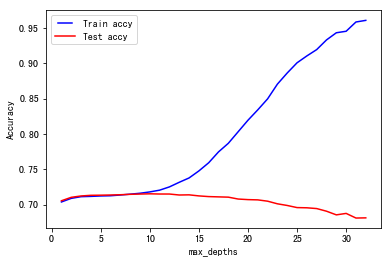

In [144]:
#find the sweet spot --> choose n=10
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(train_X, train_Y)
    train_pred = rf.predict(train_X)
    accy_train = accuracy_score(train_Y, train_pred)
    train_results.append(accy_train)
    pred_Y = rf.predict(test_X)
    accy_test = accuracy_score(test_Y, pred_Y)
    test_results.append(accy_test)

#plot
line1, = plt.plot(max_depths, train_results, 'b', label='Train accy')
line2, = plt.plot(max_depths, test_results, 'r', label='Test accy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('max_depths')
plt.show()

In [145]:
test_results, train_results

([0.7056387322574373,
  0.710519152245771,
  0.712444098775034,
  0.7133579622788256,
  0.7135329574178495,
  0.7138051720785533,
  0.7141746062609372,
  0.714757923391017,
  0.7151273575734007,
  0.7154773478514486,
  0.7151856892864087,
  0.7151662453820727,
  0.7137857281742174,
  0.7140190550262493,
  0.712521874392378,
  0.7115496791755784,
  0.7111413571845226,
  0.7107524790978028,
  0.7080886642037721,
  0.7072720202216605,
  0.7069025860392767,
  0.7050554151273576,
  0.7013416293991833,
  0.6989889169745285,
  0.6959945557067859,
  0.695702897141746,
  0.6946140384989306,
  0.6908808088664203,
  0.6857087303130469,
  0.6877697841726619,
  0.681217188411433,
  0.6814699591678008],
 [0.703934512293528,
  0.709048308849979,
  0.7114253492645272,
  0.7118433972719937,
  0.7124267200731098,
  0.712742686590381,
  0.7137878066090473,
  0.7149690352813074,
  0.716276650560476,
  0.7181481445473901,
  0.7206272664521335,
  0.7252549606743212,
  0.7317687319534508,
  0.737893621365169

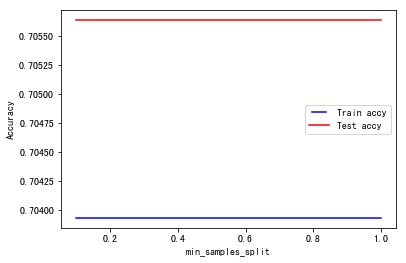

In [146]:
#find the sweet spot --> default
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=min_samples_split)
    rf.fit(train_X, train_Y)
    train_pred = rf.predict(train_X)
    accy_train = accuracy_score(train_Y, train_pred)
    train_results.append(accy_train)
    pred_Y = rf.predict(test_X)
    accy_test = accuracy_score(test_Y, pred_Y)
    test_results.append(accy_test)

#plot
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train accy')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test accy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('min_samples_split')
plt.show()

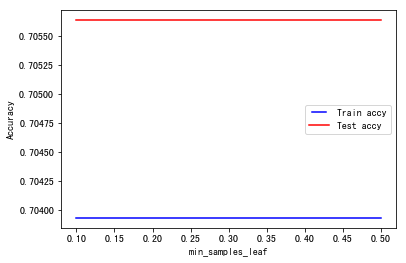

In [147]:
#find the sweet spot --> default
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
    rf.fit(train_X, train_Y)
    train_pred = rf.predict(train_X)
    accy_train = accuracy_score(train_Y, train_pred)
    train_results.append(accy_train)
    pred_Y = rf.predict(test_X)
    accy_test = accuracy_score(test_Y, pred_Y)
    test_results.append(accy_test)

#plot
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train accy')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test accy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('min_samples_leaf')
plt.show()

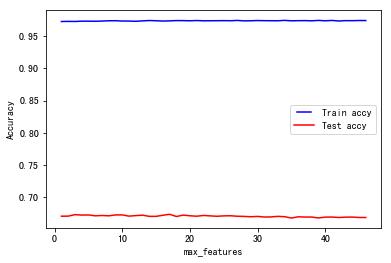

In [148]:
#find the sweet spot --> default
max_features = list(range(1,train_X.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    rf = RandomForestClassifier(max_features=max_feature)
    rf.fit(train_X, train_Y)
    train_pred = rf.predict(train_X)
    accy_train = accuracy_score(train_Y, train_pred)
    train_results.append(accy_train)
    pred_Y = rf.predict(test_X)
    accy_test = accuracy_score(test_Y, pred_Y)
    test_results.append(accy_test)

#plot
line1, = plt.plot(max_features, train_results, 'b', label='Train accy')
line2, = plt.plot(max_features, test_results, 'r', label='Test accy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('max_features')
plt.show()

In [149]:
test_results, train_results

([0.670970250826366,
  0.6710869142523819,
  0.6733812949640288,
  0.6727202022166051,
  0.672914641259965,
  0.6715924557651176,
  0.6720591094691815,
  0.6715924557651176,
  0.672934085164301,
  0.672972972972973,
  0.6710869142523819,
  0.6719035582344934,
  0.6725646509819172,
  0.67075636787867,
  0.670736923974334,
  0.6724479875559012,
  0.6739062803811006,
  0.6705424849309741,
  0.6726618705035972,
  0.6716507874781256,
  0.6709508069220299,
  0.6721174411821894,
  0.6714952362434377,
  0.67085358740035,
  0.6714952362434377,
  0.6716702313824616,
  0.670931363017694,
  0.6706785922613261,
  0.6701341629399183,
  0.6706397044526541,
  0.6696869531401906,
  0.6698813921835505,
  0.67075636787867,
  0.6702119385572622,
  0.6681314407933113,
  0.6700563873225743,
  0.6696675092358546,
  0.6696675092358546,
  0.6682869920279992,
  0.6695119580011666,
  0.6696869531401906,
  0.668967528679759,
  0.6694925140968306,
  0.6696091775228465,
  0.6689869725840949,
  0.6689480847754229],


In [150]:
#from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 32 ,max_depth=10, max_features='auto')
rf.fit(train_X, train_Y)

#cross validation score
#score = cross_val_score(rf, train_X, train_Y, cv=5).mean()
#print("cross validation score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

#accuracy
pred_Y = rf.predict(test_X)
accy = accuracy_score(test_Y, pred_Y)
print('accuracy: %0.2f' %accy)

#confusion matrix
labels = np.unique(test_Y)
m = confusion_matrix(test_Y, pred_Y, labels=labels)
pd.DataFrame(m, index=labels, columns=labels)

accuracy: 0.72


,A,B,C,D,E,F,Loss
A,990,0,0,0,0,0,3944
B,215,0,0,0,0,0,2790
C,108,0,0,0,0,0,1279
D,23,0,0,0,0,0,286
E,137,0,0,0,0,0,2997
F,65,0,0,0,0,0,2305
Loss,503,0,0,0,0,0,35788


找到能讓預測結果最好的參數值之後，我再去跑RF的模型，發現準確率為72%，但從confusion matrix卻發現模型只會預測A或Loss，很有問題

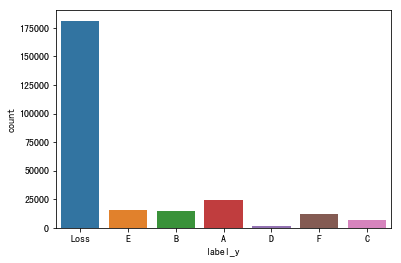

In [421]:
agg_behavior['label_y'].value_counts()
sns.countplot(data = agg_behavior, x = 'label_y')
#分佈不平衡

去看類別的數量分布，發現幾乎都是Loss，資料分布很不平衡，因此接下來要處理的事分佈不平衡的問題！


### 解決分佈不平衡的問題

google發現，解決分佈不平衡主要有幾種做法，第一種是resample，包含under-sampling和over-sampling，但這兩個都會產生明顯的缺點。因此我用第二種SMOTE，從minority的資料點去產生新的樣本點，看結果會不會好一點

In [182]:
#measure 1: SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE()
sm_X, sm_Y = sm.fit_sample(train_X, train_Y)

In [183]:
rf.fit(sm_X, sm_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [184]:
sm_pred = rf.predict(test_X)

In [185]:
#confusion matrix
labels = np.unique(sm_Y)
m = confusion_matrix(test_Y, sm_pred, labels=labels)
pd.DataFrame(m, index=labels, columns=labels)

,A,B,C,D,E,F,Loss
A,1791,70,9,1,45,34,2984
B,528,52,12,2,32,36,2343
C,235,16,3,0,14,13,1106
D,51,2,3,0,2,3,248
E,382,35,11,6,54,36,2610
F,192,45,11,2,40,57,2023
Loss,1801,422,158,47,503,515,32845


In [191]:
print(accuracy_score(test_Y, sm_pred), f1_score(test_Y, sm_pred,average='macro'))
print(recall_score(test_Y, sm_pred,average='macro'), precision_score(test_Y, sm_pred,average='macro'))

0.6766867587011471 0.18222412832780116
0.18982646560280778 0.1941873021383669


用SMOTE有讓預測的分佈「均衡」一點（沒有都只預測A或Loss），但結果仍不是很好。把precision, recall, f1-score拿出來看，都不到20%。

因此我想用另種做法，分成兩階段，第一階段直接去預測「是否留存」（binary prediction），若預測會留存，第二階段再進一步去預測所屬的貢獻度類別。

In [194]:
#mesure 2 
def loss(row):
    label = row['label_y']
    Loss = False
    if label == 'Loss':
        Loss = True
    return Loss
    
df_binary = agg_behavior
df_binary['Loss'] = df_binary.apply(loss, axis=1)

In [196]:
df_binary.head()

,MemberId,ECouponDiscount,PromotionDiscount,"cut_UnitPrice_(399.0, 2800.0]","cut_UnitPrice_(299.0, 399.0]","cut_UnitPrice_(225.0, 299.0]","cut_UnitPrice_(199.0, 225.0]","cut_UnitPrice_(0.0, 199.0]",get_OpenCardPresent,get_LastBirthdayPresentYear,location_North,location_South,location_Mid,location_East,Weekend,time_Midnight,time_Morning,time_Afternoon,time_Night,season_spring,season_summer,season_fall,season_winter,TrackSourceTypeDef_AndroidApp,TrackSourceTypeDef_Web,TrackSourceTypeDef_iOSApp,TrackDeviceTypeDef_Mobile,TrackDeviceTypeDef_PC,TrackDeviceTypeDef_Pad,PayProfileTypeDef_CreditCardOnce,PayProfileTypeDef_Family,PayProfileTypeDef_SevenEleven,DeliverTypeDef_Family,DeliverTypeDef_Home,DeliverTypeDef_SevenEleven,GenderTypeDef_Female,GenderTypeDef_Male,GenderTypeDef_N,RegisterSourceTypeDef_AndroidApp,RegisterSourceTypeDef_N,RegisterSourceTypeDef_Web,RegisterSourceTypeDef_iOSApp,Npurchase,Return,label_x,log_Quantity,log_SalesOrderSlaveTotalPayment,log_frequency_mean,label_y,rank_x,Loss
0,1362,0.0,0.0,0,0,1,0,3,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0.0,E,1.609438,6.383507,5.902633,Loss,2,True
1,1384,0.0,0.0,1,0,1,0,2,0.0,0.0,0,2,0,0,0,0,1,0,1,1,0,1,0,0,2,0,2,0,0,2,0,0,0,2,0,0,0,2,0,0,2,0,2,0.0,C,1.609438,7.045777,5.278115,E,4,False
2,1400,0.0,0.0,0,2,0,0,0,0.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0.0,E,1.098612,6.683361,5.902633,Loss,2,True
3,1448,0.0,0.0,0,2,4,2,5,0.0,0.0,0,0,3,0,1,0,1,1,1,1,2,0,0,0,3,0,2,1,0,0,0,3,0,0,3,0,0,3,0,0,3,0,3,0.0,A,2.639057,8.032360,4.248495,B,6,False
4,1469,0.0,2.0,2,3,2,0,2,4.0,4.0,2,2,0,0,1,3,1,0,0,0,2,1,1,4,0,0,4,0,0,0,2,2,2,0,2,4,0,0,0,4,0,0,4,0.0,A,2.302585,7.926242,4.043051,Loss,6,True


In [398]:
df_binary['Loss'].value_counts()

True     181103
False     76045
Name: Loss, dtype: int64

把資料拆成training set與testing set

In [291]:
train_Y_label = df_binary['label_y']

drop_list = ['label_x', 'MemberId', 'label_y', 'Loss']
train_X = df_binary.drop(drop_list ,axis=1)

train_X = train_X.values
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y_label, test_size=0.2)

In [323]:
train_Y_binary = train_Y.copy()
train_Y_binary[train_Y_binary != 'Loss'] = False
train_Y_binary[train_Y_binary == 'Loss'] = True
train_Y_binary = train_Y_binary.tolist()

In [324]:
test_Y_binary = test_Y.copy()
test_Y_binary[test_Y_binary != 'Loss'] = False
test_Y_binary[test_Y_binary == 'Loss'] = True
test_Y_binary = test_Y_binary.tolist()

第一階段：預測是否留存

一樣先去找RF的最佳參數，評價指標我選用precision，增加判定為true的門檻。

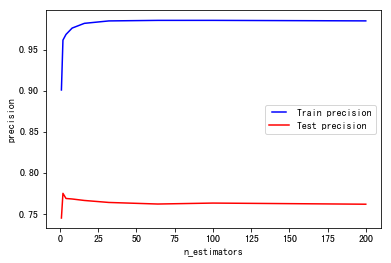

In [400]:
#find the sweet spot 
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200] #take n=2
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(train_X, train_Y_binary)
    train_pred = rf.predict(train_X)
    
    precision_train = precision_score(train_Y_binary, train_pred)
    train_results.append(precision_train)
    pred_Y = rf.predict(test_X)
    precision_test = precision_score(test_Y_binary, pred_Y)
    test_results.append(precision_test)
    

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train precision')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test precision')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('precision')
plt.xlabel('n_estimators')
plt.show()

In [401]:
test_results, train_results

([0.7448469359408856,
  0.774910394265233,
  0.7686602870813397,
  0.7680463531747096,
  0.7662468260552581,
  0.7638211677946777,
  0.7619115890083632,
  0.7630683575626354,
  0.7616822429906542],
 [0.9007531079547028,
  0.9614867421954892,
  0.968388644255898,
  0.9761047350697547,
  0.981876638269987,
  0.984831928755822,
  0.985492992377674,
  0.9855018028846154,
  0.9848726657663925])

ValueError: x and y must have same first dimension, but have shapes (32,) and (9,)

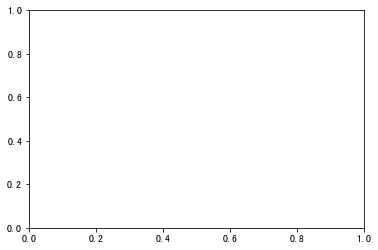

In [394]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200] #take n=16
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(train_X, train_Y_binary)
    train_pred = rf.predict(train_X)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_Y_binary, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    pred_Y = rf.predict(test_X)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_Y_binary, pred_Y)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

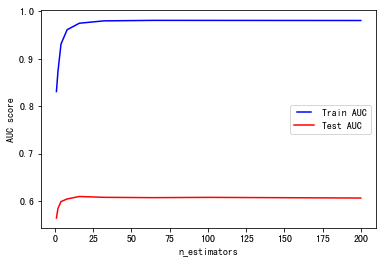

In [397]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

In [399]:
test_results, train_results

([0.5641883956777619,
  0.5842274080682783,
  0.5989195319702401,
  0.6044665413519218,
  0.6096364858476595,
  0.6079070737573863,
  0.6072062458247159,
  0.6077916375163895,
  0.606400968608725],
 [0.8310348357178848,
  0.873212075581881,
  0.9312765485389284,
  0.9615142575077512,
  0.9751902727196946,
  0.9801804063208509,
  0.9812295604083562,
  0.9811631469373929,
  0.9809462156137685])

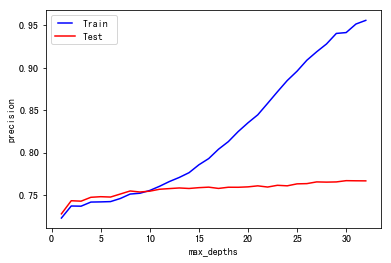

In [402]:
max_depths = np.linspace(1, 32, 32, endpoint=True) #n=30
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(train_X, train_Y_binary)
    train_pred = rf.predict(train_X)
    
    precision_train = precision_score(train_Y_binary, train_pred)
    train_results.append(precision_train)
    pred_Y = rf.predict(test_X)
    precision_test = precision_score(test_Y_binary, pred_Y)
    test_results.append(precision_test)
#plot
line1, = plt.plot(max_depths, train_results, 'b', label='Train ')
line2, = plt.plot(max_depths, test_results, 'r', label='Test ')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('precision')
plt.xlabel('max_depths')
plt.show()

In [403]:
test_results, train_results

([0.7276392811822014,
  0.7431231665320353,
  0.7426159440321517,
  0.7471797415931494,
  0.7478868380196654,
  0.7474738769794248,
  0.7510474329751439,
  0.7546386772358973,
  0.7534276626083142,
  0.7543979092087058,
  0.7566792419529199,
  0.7574553125346952,
  0.7581994570780116,
  0.7575872280733005,
  0.7585474385635383,
  0.7591478471692183,
  0.7576473234367971,
  0.7590497737556561,
  0.7590013857022785,
  0.759491649174044,
  0.76069279184086,
  0.7592767694471991,
  0.7613363485883478,
  0.7607183151560737,
  0.763038926429999,
  0.7633209714080632,
  0.7653427850067974,
  0.7650805270863836,
  0.7653174897883401,
  0.7668074534161491,
  0.7666541117388574,
  0.7665693724523175],
 [0.7227005680392147,
  0.7369168497252792,
  0.7366937842292763,
  0.7415503951341511,
  0.7417585378207407,
  0.7420993106419647,
  0.7457661158998632,
  0.7510055586955449,
  0.7519690653795524,
  0.755246062018401,
  0.76020137491987,
  0.7657955158247024,
  0.7705840094893884,
  0.776235635389

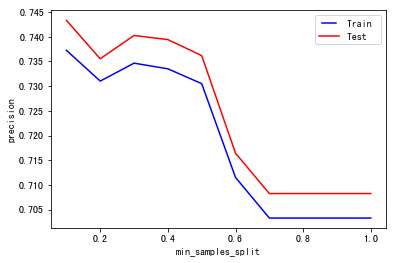

In [404]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True) #0.1
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=min_samples_split)
    rf.fit(train_X, train_Y_binary)
    train_pred = rf.predict(train_X)
    
    precision_train = precision_score(train_Y_binary, train_pred)
    train_results.append(precision_train)
    pred_Y = rf.predict(test_X)
    precision_test = precision_score(test_Y_binary, pred_Y)
    test_results.append(precision_test)

#plot
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train ')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test ')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('precision')
plt.xlabel('min_samples_split')
plt.show()

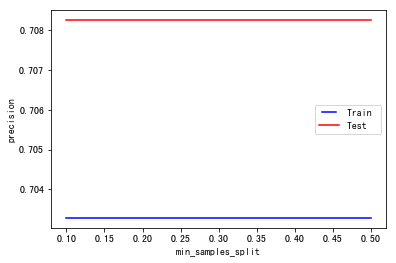

In [406]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
    rf.fit(train_X, train_Y_binary)
    train_pred = rf.predict(train_X)
    
    precision_train = precision_score(train_Y_binary, train_pred)
    train_results.append(precision_train)
    pred_Y = rf.predict(test_X)
    precision_test = precision_score(test_Y_binary, pred_Y)
    test_results.append(precision_test)

#plot
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train ')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test ')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('precision')
plt.xlabel('min_samples_split')
plt.show()

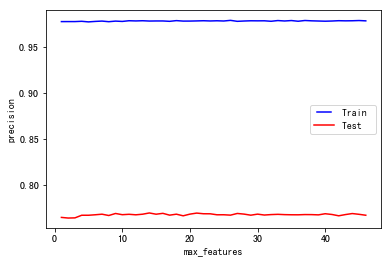

In [407]:
#find the sweet spot --> default or 9
max_features = list(range(1,train_X.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    rf = RandomForestClassifier(max_features=max_feature)
    rf.fit(train_X, train_Y_binary)
    train_pred = rf.predict(train_X)
    
    precision_train = precision_score(train_Y_binary, train_pred)
    train_results.append(precision_train)
    pred_Y = rf.predict(test_X)
    precision_test = precision_score(test_Y_binary, pred_Y)
    test_results.append(precision_test)
#plot
line1, = plt.plot(max_features, train_results, 'b', label='Train ')
line2, = plt.plot(max_features, test_results, 'r', label='Test ')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('precision')
plt.xlabel('max_features')
plt.show()

In [408]:
test_results, train_results

([0.7645747466106747,
  0.7638820575215511,
  0.7640644876554428,
  0.7669268800416341,
  0.766912989175687,
  0.7674406483725537,
  0.7680719740558636,
  0.7666431427899317,
  0.7688463249339299,
  0.7675256376544833,
  0.7679597135887953,
  0.7674071748174895,
  0.76805348794693,
  0.769406392694064,
  0.7680579528218003,
  0.7689928170712526,
  0.7670260320799369,
  0.7680866691149467,
  0.7663098945385078,
  0.7681429396022459,
  0.7692692297571116,
  0.7685487265838771,
  0.7685031486312017,
  0.7674253760730881,
  0.767454109715309,
  0.7670409615688756,
  0.7688680487869128,
  0.7681617182564751,
  0.7669933607334809,
  0.7681307993586205,
  0.7671593813400785,
  0.7676432651557029,
  0.7679190827971509,
  0.7675929363101236,
  0.7674400190038799,
  0.7674069390658342,
  0.7676591239910017,
  0.7676006220511874,
  0.7673382205579874,
  0.7685716552508397,
  0.7677580539119001,
  0.7663221179200507,
  0.7676706243223947,
  0.7687647167764637,
  0.7679445458634283,
  0.76692863380

In [412]:
#from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=2, max_depth=30, min_samples_split=0.1, max_features=9 )
rf.fit(train_X, train_Y_binary)

#cross validation score
#score = cross_val_score(rf, train_X, train_Y, cv=5).mean()
#print("cross validation score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

#evaluation
pred_Y_binary = rf.predict(test_X)
accy = accuracy_score(test_Y_binary, pred_Y_binary)
precision= precision_score(test_Y_binary, pred_Y_binary)
recall = recall_score(test_Y_binary, pred_Y_binary)
print('accuracy: %0.2f' %accy, 'precision: %0.2f' %precision, 'recall: %0.2f' %recall)

#confusion matrix
labels = np.unique(test_Y_binary)
m = confusion_matrix(test_Y_binary, pred_Y_binary, labels=labels)
pd.DataFrame(m, index=labels, columns=labels)

accuracy: 0.73 precision: 0.75 recall: 0.93


,False,True
False,3771,11234
True,2469,33956


第一階段的預測結果有比前面兩個模型好，但還是不太滿意

第二階段：把testing set裡面預測為「會留存」的會員，再拿去預測所屬類別

In [413]:
#把裡面預測為不會流失的再拿去預測類別
index = []
for i in range(len(pred_Y_binary)):
    if pred_Y_binary[i] == False:
        index.append(i)      

In [414]:
test_X_retain = []
test_X_list = test_X.tolist()
for i in index:
    test_X_retain.append(test_X_list[i])   
test_X_retain = np.asarray(test_X_retain)

In [415]:
test_Y_retain = []
test_Y_list = test_Y.tolist()
for i in index:
    test_Y_retain.append(test_Y_list[i])
test_Y_retain = np.asarray(test_Y_retain)

In [416]:
index = []
train_Y_list = train_Y.tolist()
for i in range(len(train_Y_list)):
    if train_Y_list[i] != 'Loss':
        index.append(i)  

In [417]:
train_X_retain = []
train_Y_retain = []
for i in index:
    train_X_retain.append(train_X[i])
    train_Y_retain.append(train_Y_list[i])
train_X_retain = np.asarray(train_X_retain)

In [418]:
#from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(train_X_retain, train_Y_retain)

#cross validation score
#score = cross_val_score(rf, train_X, train_Y, cv=5).mean()
#print("cross validation score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

#accuracy
pred_Y_retain = rf.predict(test_X_retain)
accy = accuracy_score(test_Y_retain, pred_Y_retain)
precision= precision_score(test_Y_retain, pred_Y_retain, average = 'macro')
recall = recall_score(test_Y_retain, pred_Y_retain, average = 'macro')
print('accuracy: %0.2f' %accy, 'precision: %0.2f' %precision, 'recall: %0.2f' %recall)

#confusion matrix
labels = np.unique(test_Y_retain)
m = confusion_matrix(test_Y_retain, pred_Y_retain, labels=labels)
pd.DataFrame(m, index=labels, columns=labels)

accuracy: 0.28 precision: 0.10 recall: 0.16


,A,B,C,D,E,F,Loss
A,1621,145,19,0,92,22,0
B,543,70,8,0,47,20,0
C,223,30,7,0,20,2,0
D,46,10,0,0,2,2,0
E,398,64,7,0,46,19,0
F,222,44,5,1,26,10,0
Loss,1816,312,36,2,237,66,0


結果不好，推測可能是因為第一階段準確率不夠高，會影響到第二階段的準確度衡量

### To-Do:
- 解決分佈不平衡的問題：試試其他resample的方法
- 多類別預測改為二元預測：把每個類別的預測改成是二元問題，再集成，看結果會不會更準
- 刪減不重要的特徵